In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import requests
from roboflow import Roboflow
from fastapi import FastAPI, UploadFile
import os

In [3]:
os.environ['WANDB_DISABLED'] = 'true'

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


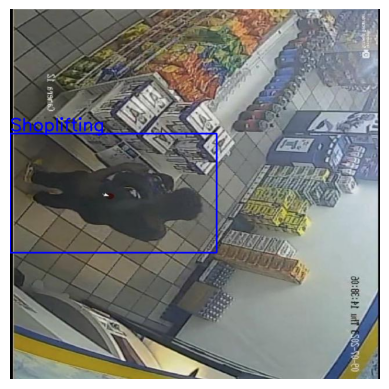

In [4]:
def read_label_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        line = line.strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:])
        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        boxes.append((x1, y1, x2, y2, class_id))
    return boxes

def draw_boxes(image, boxes,labels):
    for box in boxes:
        x1, y1, x2, y2, class_id = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = labels[class_id]
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

# Load image
image_path = r"Shoplifting-Detection-2-Small/train/images/aahil_1_mp4-89_jpg.rf.e8c625beadbbf5e68a85e62fd842ed05.jpg"
image = cv2.imread(image_path)
img_height, img_width, _ = image.shape

# Read label file
label_file = r"Shoplifting-Detection-2-Small/train/labels/aahil_1_mp4-89_jpg.rf.e8c625beadbbf5e68a85e62fd842ed05.txt"
boxes = read_label_file(label_file)

# Define class names (assuming class IDs are indices)
class_names =  ["Shoplifting","normal"]

# Draw bounding boxes with labels
image_with_boxes = draw_boxes(image.copy(), boxes, class_names)

# Display image with bounding boxes
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [5]:
# ##### Blur faces and Convert images to GrayScale

# import cv2
# import os

# def blur_convert_to_grayscale(input_folder, output_folder):
#     for filename in os.listdir(input_folder):
#         img = cv2.imread(os.path.join(input_folder, filename))

#         if img is not None:

#             # Blur Faces

#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#             face_detect = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml') 
#             face_data = face_detect.detectMultiScale(img, 1.3, 5) 
            
#             # Draw rectangle around the faces which is our region of interest (ROI) 
#             for (x, y, w, h) in face_data: 
#                 #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2) 
#                 roi = img[y:y+h, x:x+w] 
#                 # applying a gaussian blur over this new rectangle area 
#                 roi = cv2.GaussianBlur(roi, (23, 23), 30) 
#                 # impose this blurred image on original image to get final image 
#                 img[y:y+roi.shape[0], x:x+roi.shape[1]] = roi 

#             # Grayscale images

#             gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#             cv2.imwrite(os.path.join(output_folder, filename), gray)

# blur_convert_to_grayscale(r"Shoplifting-Detection-2-Small\train\images",r"Shoplifting-Detection-2-Small\train_gray_blur\images")
# blur_convert_to_grayscale(r"Shoplifting-Detection-2-Small\valid\images",r"Shoplifting-Detection-2-Small\valid_gray_blur\images")

In [6]:
# ##### Convert to HSV since it eliminates skin color 

# import cv2
# import os

# def blur_convert_to_grayscale(input_folder, output_folder):
#     for filename in os.listdir(input_folder):
#         img = cv2.imread(os.path.join(input_folder, filename))

#         if img is not None:

#             # Apply HSV

#             hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#             cv2.imwrite(os.path.join(output_folder, filename), hsv_img)

# blur_convert_to_grayscale(r"Shoplifting-Detection-2-Small\train\images",r"Shoplifting-Detection-2-Small\train_gray_blur\images")
# blur_convert_to_grayscale(r"Shoplifting-Detection-2-Small\valid\images",r"Shoplifting-Detection-2-Small\valid_gray_blur\images")

In [7]:
##### Convert to Edge since it eliminates skin color 

import cv2
import os

def convert_to_edge(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        img = cv2.imread(os.path.join(input_folder, filename))

        if img is not None:

            # Apply HSV
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Read as grayscale
            # Apply Canny edge detection
            edges = cv2.Canny(gray_img, 100, 200)

            cv2.imwrite(os.path.join(output_folder, filename), edges)

convert_to_edge(r"Shoplifting-Detection-2-Small\train\images",r"Shoplifting-Detection-2-Small\train_edge\images")
convert_to_edge(r"Shoplifting-Detection-2-Small\valid\images",r"Shoplifting-Detection-2-Small\valid_edge\images")

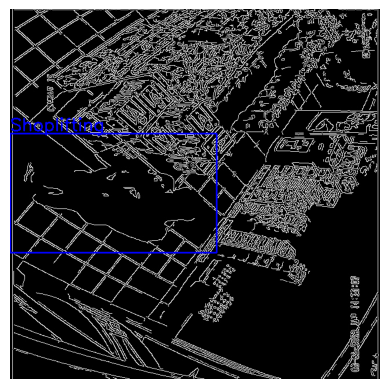

In [8]:
def read_label_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        line = line.strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:])
        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        boxes.append((x1, y1, x2, y2, class_id))
    return boxes

def draw_boxes(image, boxes,labels):
    for box in boxes:
        x1, y1, x2, y2, class_id = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = labels[class_id]
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

# Load image
image_path = r"Shoplifting-Detection-2-Small/train_edge/images/aahil_1_mp4-89_jpg.rf.e8c625beadbbf5e68a85e62fd842ed05.jpg"
image = cv2.imread(image_path)
img_height, img_width, _ = image.shape

# Read label file
label_file = r"Shoplifting-Detection-2-Small/train_edge/labels/aahil_1_mp4-89_jpg.rf.e8c625beadbbf5e68a85e62fd842ed05.txt"
boxes = read_label_file(label_file)

# Define class names (assuming class IDs are indices)
class_names =  ["Shoplifting","normal"]

# Draw bounding boxes with labels
image_with_boxes = draw_boxes(image.copy(), boxes, class_names)

# Display image with bounding boxes
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Object Detection Modelling (ML)

### Yolo8

#### Train

In [9]:
# Load the model.
model = YOLO('yolov8n.pt')
 
# Training.``
results = model.train(
   data=r'C:\Users\abhij\Documents\EAI 6400\Final Project - Person Recognition\Shoplifting-Detection-2-Small\data_edge.yaml',
   imgsz=640,
   epochs=25,   
   name='Shoplift_Detect_Edge_Final')

New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.11.8 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\abhij\Documents\EAI 6400\Final Project - Person Recognition\Shoplifting-Detection-2-Small\data_edge.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Shoplift_Detect_Edge_Final4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, strea

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning C:\Users\abhij\Documents\EAI 6400\Final Project - Person Recognition\Shoplifting-Detection-2-Small\train_edge\labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\abhij\Documents\EAI 6400\Final Project - Person Recognition\Shoplifting-Detection-2-Small\valid_edge\labels.cache... 106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 106/106 [00:00<?, ?it/s]


Plotting labels to runs\detect\Shoplift_Detect_Edge_Final4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\Shoplift_Detect_Edge_Final4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.19G      1.825      3.151      1.833         14        640: 100%|██████████| 39/39 [00:16<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        106        109    0.00347      0.972      0.321      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       2.1G      1.484      2.247      1.446         14        640: 100%|██████████| 39/39 [00:06<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        106        109      0.415      0.429       0.47      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       2.1G      1.513      2.089      1.444         12        640: 100%|██████████| 39/39 [00:06<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

                   all        106        109      0.344      0.853      0.444      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       2.1G      1.508      1.889      1.454         14        640: 100%|██████████| 39/39 [00:06<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all        106        109      0.466      0.596      0.513       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       2.1G      1.497      1.707      1.423         20        640: 100%|██████████| 39/39 [00:06<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

                   all        106        109      0.322       0.55       0.37      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.09G      1.453      1.593      1.375          7        640: 100%|██████████| 39/39 [00:06<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        106        109      0.674      0.832      0.825      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       2.2G      1.406      1.443      1.342         12        640: 100%|██████████| 39/39 [00:06<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

                   all        106        109      0.862      0.568      0.755      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       2.1G      1.368      1.337      1.321         15        640: 100%|██████████| 39/39 [00:06<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        106        109      0.813      0.648      0.739      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       2.1G      1.341      1.298      1.306         13        640: 100%|██████████| 39/39 [00:06<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        106        109      0.724      0.668      0.743      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.09G      1.332      1.206       1.29         11        640: 100%|██████████| 39/39 [00:06<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

                   all        106        109      0.845      0.825      0.897      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       2.2G      1.295      1.107      1.271         11        640: 100%|██████████| 39/39 [00:06<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        106        109      0.817      0.748      0.817      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.1G      1.259      1.052       1.25         10        640: 100%|██████████| 39/39 [00:06<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

                   all        106        109       0.94      0.862      0.955       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       2.1G      1.256      1.039      1.242         11        640: 100%|██████████| 39/39 [00:06<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        106        109      0.914       0.82      0.894        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.09G      1.176     0.9546      1.217         13        640: 100%|██████████| 39/39 [00:06<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all        106        109      0.722      0.834      0.851      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       2.2G      1.192     0.9113      1.222          8        640: 100%|██████████| 39/39 [00:06<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        106        109      0.748      0.815      0.815      0.547


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


In [5]:
best_model_source = r'runs\detect\Shoplift_Detect_Edge_Final\weights\best.pt'
model = YOLO(best_model_source)  # pretrained YOLOv8n model

In [7]:
# Validate the model
metrics = model.val(name='Shoplift_Detect_Edge_Final_Val')  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.1.34 🚀 Python-3.11.8 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)


val: Scanning C:\Users\abhij\Documents\EAI 6400\Final Project - Person Recognition\Shoplifting-Detection-2-Small\valid_edge\labels.cache... 106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 106/106 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all        106        109       0.94      0.862      0.955       0.61
           Shoplifting        106         55      0.951      0.909       0.98      0.569
                normal        106         54      0.928      0.815      0.931      0.652
Speed: 1.7ms preprocess, 9.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\detect\Shoplift_Detect_Edge_Final_Val


array([    0.56869,     0.65206])

In [31]:
print("F1 score : " +str(round(metrics.box.f1.mean()*100))+" %")

F1 score : 90 %



0: 640x640 1 Shoplifting, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 418.7ms postprocess per image at shape (1, 3, 640, 640)


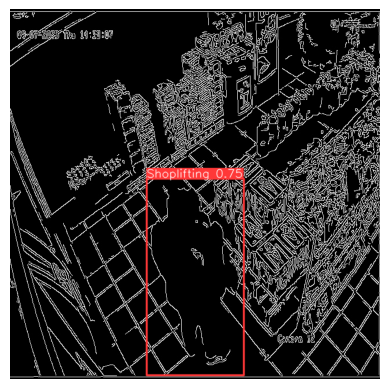

In [6]:
# Load an image
source1 = r'Shoplifting-Detection-2-Small/valid_edge/images/aahil_1_mp4-98_jpg.rf.4fea4d6fed6f0a503b70cfa1c8ac97e5.jpg'

# Run batched inference on a list of images
results = model([source1])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)  # show image
    plt.axis('off')
    plt.show()